<a href="https://www.kaggle.com/code/adityanafrianda/03-aditya-nur-afrianda?scriptVersionId=106871719" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
import operator as op
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [328]:
customer = pd.read_csv('../input/brazilian-ecommerce/olist_customers_dataset.csv')
geolocation = pd.read_csv('../input/brazilian-ecommerce/olist_geolocation_dataset.csv')
oitems = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
opayments = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
oreview = pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
products = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')
sellers = pd.read_csv('../input/brazilian-ecommerce/olist_sellers_dataset.csv')
pcategory = pd.read_csv('../input/brazilian-ecommerce/product_category_name_translation.csv')

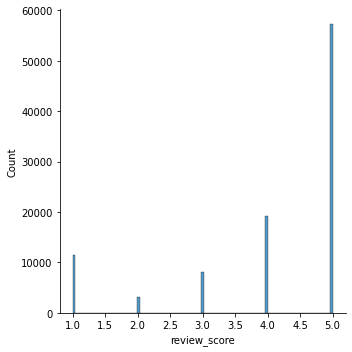

In [395]:
sns.displot(oreview['review_score'])

**====MOST FAVORABLE PAYMENT TYPE====**

In [330]:
co = pd.merge(customer, orders)
cop = pd.merge (co, opayments)

In [331]:
customerpay = cop[['customer_id','payment_type']].drop_duplicates()
customerpay.groupby(['payment_type']).agg('count').reset_index().sort_values('customer_id', ascending=False)

,payment_type,customer_id
1,credit_card,76505
0,boleto,19784
4,voucher,3866
2,debit_card,1528
3,not_defined,3


**====SEGMENTATION BASED ON PRODUCTS DIMENSION====**

In [332]:
op = pd.merge(oitems, products)
opo = pd.merge(op, orders)

In [365]:
dp = opo[['customer_id', 'product_length_cm', 'product_height_cm', 'product_width_cm']]
dp['product_dimension'] = (opo.product_length_cm * opo.product_height_cm * opo.product_width_cm)
dp.head()

,customer_id,product_length_cm,product_height_cm,product_width_cm,product_dimension
0,3ce436f183e68e07877b285a838db11a,28.0,9.0,14.0,3528.0
1,e6eecc5a77de221464d1c4eaff0a9b64,28.0,9.0,14.0,3528.0
2,4ef55bf80f711b372afebcb7c715344a,28.0,9.0,14.0,3528.0
3,30407a72ad8b3f4df4d15369126b20c9,28.0,9.0,14.0,3528.0
4,91a792fef70ecd8cc69d3c7feb3d12da,28.0,9.0,14.0,3528.0


In [334]:
dp['product_dimension'].min()

168.0

In [335]:
dp['product_dimension'].max()

296208.0

In [376]:
def get_dimensions (dp):
    if dp['product_dimension'] > 148.104:
        return 'Large'
    elif (dp['product_dimension'] <= 148.104) and (dp['product_dimension'] > 37.026):
        return 'Medium'
    elif dp['product_dimension'] <= 37.026: 
        return 'Small'
dp['product_segmentation']=dp.apply(get_dimensions,axis=1)
dp.head()

,customer_id,product_length_cm,product_height_cm,product_width_cm,product_dimension,product_segmentation
0,3ce436f183e68e07877b285a838db11a,28.0,9.0,14.0,3528.0,Large
1,e6eecc5a77de221464d1c4eaff0a9b64,28.0,9.0,14.0,3528.0,Large
2,4ef55bf80f711b372afebcb7c715344a,28.0,9.0,14.0,3528.0,Large
3,30407a72ad8b3f4df4d15369126b20c9,28.0,9.0,14.0,3528.0,Large
4,91a792fef70ecd8cc69d3c7feb3d12da,28.0,9.0,14.0,3528.0,Large


**====CITY WITH THE MOST ORDERS====**

In [337]:
customercity = cop[['customer_id','customer_city']].drop_duplicates()
customercity = customercity.groupby(['customer_city']).agg('count').reset_index().sort_values('customer_id', ascending=False)
customercity.head()

,customer_city,customer_id
3597,sao paulo,15540
3155,rio de janeiro,6882
453,belo horizonte,2773
558,brasilia,2131
1143,curitiba,1521


**====Customer RFM(Recency, Frequency, Monetary) For City With The Most Orders====**

In [ ]:
ccsp = cop.loc[cop['customer_city'] == 'sao paulo']
ccsp.isnull().sum(axis=0)

**#CLEAN THE MISSING VALUE#**

In [339]:
ccsp = ccsp[pd.notnull(ccsp['order_approved_at'])]
ccsp = ccsp[pd.notnull(ccsp['order_delivered_carrier_date'])]
ccsp = ccsp[pd.notnull(ccsp['order_delivered_customer_date'])]

In [340]:
ccsp['order_purchase_timestamp'].max()

'2018-08-29 12:25:59'

In [341]:
import datetime as dt
now = dt.datetime(2018, 8, 30)
ccsp['order_purchase_timestamp'] = pd.to_datetime(ccsp['order_purchase_timestamp'])

In [342]:
rfmtable = ccsp.groupby('customer_id').agg({'order_purchase_timestamp': 
lambda x: (now - x.max()).days,'order_id': lambda x:len(x),
'payment_value':lambda x: x.sum()})
rfmtable['order_purchase_timestamp'] = rfmtable['order_purchase_timestamp'].astype(int)
rfmtable.rename(columns={'order_purchase_timestamp': 'Recency', 
                         'order_id': 'Frequency', 
                         'payment_value': 'Monetary'}, inplace=True)
rfmtable.head(3)

,Recency,Frequency,Monetary
customer_id,,,
000379cdec625522490c315e70c7a9fb,149,1,107.01
0005aefbb696d34b3424dccd0a0e9fd0,70,1,147.33
00062b33cb9f6fe976afdcff967ea74d,532,1,58.95


**===RFM SCORE CUSTOMER SEGMENTATION AT SAO PAULO===**

In [344]:
quantiles = rfmtable.quantile(q=[0.25, 0.5, 0.75])
quantiles = quantiles.to_dict()
rfm_segment = rfmtable

In [345]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [346]:
rfm_segment['R'] = rfm_segment['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segment['F'] = rfm_segment['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segment['M'] = rfm_segment['Monetary'].apply(FMScore, args=('Monetary',quantiles,))
rfm_segment.head(3)

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
000379cdec625522490c315e70c7a9fb,149,1,107.01,2,4,2
0005aefbb696d34b3424dccd0a0e9fd0,70,1,147.33,1,4,2
00062b33cb9f6fe976afdcff967ea74d,532,1,58.95,4,4,3


In [347]:
rfm_segment['RFMScore'] = rfm_segment.R.map(str) + rfm_segment.F.map(str) + rfm_segment.F.map(str)
rfm_segment['Score'] = rfm_segment[['R', 'F', 'M']].sum(axis=1)
rfm_segment.head(3)

,Recency,Frequency,Monetary,R,F,M,RFMScore,Score
customer_id,,,,,,,,
000379cdec625522490c315e70c7a9fb,149,1,107.01,2,4,2,244,8
0005aefbb696d34b3424dccd0a0e9fd0,70,1,147.33,1,4,2,144,7
00062b33cb9f6fe976afdcff967ea74d,532,1,58.95,4,4,3,444,11


In [348]:
loyalty_level = ['Platinum', 'Gold', 'Silver', 'Bronze']
def level_customer(rfm_segment):
   if (rfm_segment['Score'] <=12) and (rfm_segment['Score'] > 9):
      return 'Bronze'
   elif (rfm_segment['Score'] <=9) and (rfm_segment['Score'] > 6):
      return 'Silver'
   elif (rfm_segment['Score'] <=6) and (rfm_segment['Score'] > 3):
      return 'Gold'
   elif rfm_segment['Score'] <= 3:
      return 'Platinum'
rfm_segment['Customer Level']=rfm_segment.apply(level_customer,axis=1)
rfm_segment.head()

,Recency,Frequency,Monetary,R,F,M,RFMScore,Score,Customer Level
customer_id,,,,,,,,,
000379cdec625522490c315e70c7a9fb,149,1,107.01,2,4,2,244,8,Silver
0005aefbb696d34b3424dccd0a0e9fd0,70,1,147.33,1,4,2,144,7,Silver
00062b33cb9f6fe976afdcff967ea74d,532,1,58.95,4,4,3,444,11,Bronze
001028b78fd413e19704b3867c369d3a,139,1,37.61,2,4,4,244,10,Bronze
001051abfcfdbed9f87b4266213a5df1,91,3,65.20,1,1,3,111,5,Gold


**====TOP 5 BEST CUSTOMER BASED ON RFM SCORE AT SAO PAOLO====**

In [349]:
rfm_segment[rfm_segment['RFMScore']=='111'].sort_values('Monetary', ascending= False).head()

,Recency,Frequency,Monetary,R,F,M,RFMScore,Score,Customer Level
customer_id,,,,,,,,,
9cf0a858f5f153406bc333860eb23e22,13,2,2323.25,1,1,1,111,3,Platinum
0d15109f485330cb77c3721039e60cdd,92,2,1038.90,1,1,1,111,3,Platinum
911035bc0dcc0c5ee9580cbe3e59ed06,26,3,599.26,1,1,1,111,3,Platinum
61ec27a2b6b84f5cf31fef5553c1953b,34,2,521.20,1,1,1,111,3,Platinum
7d68e1861e0a36c2876e702fec92adf0,10,2,452.59,1,1,1,111,3,Platinum


<AxesSubplot:xlabel='Monetary', ylabel='Density'>

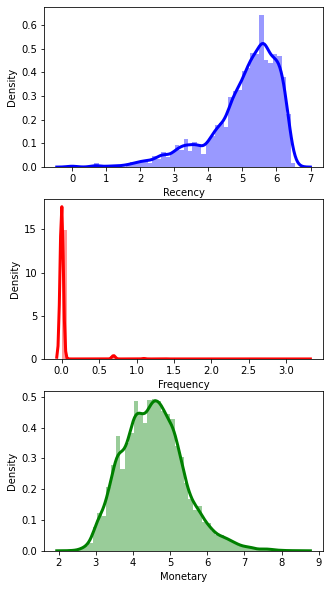

In [400]:
clustering = rfm_segment[['Recency',"Frequency","Monetary"]].copy()
clustering.head()
import numpy as np
def handle_o_n_min (num):
    if num <=1:
       return 1
    else:
       return num
clustering['Recency']=[handle_o_n_min(x) for x in clustering.Recency]
clustering['Monetary']=[handle_o_n_min(x) for x in clustering.Monetary]
clustering['Frequency']=[handle_o_n_min(x) for x in clustering.Frequency]
data_norm = clustering.apply(np.log,axis=1)
plt.figure(figsize=(5,10))
plt.subplot(3,1,1)
Recency_Plot = data_norm['Recency']
sns.distplot(Recency_Plot,kde_kws={"color":"b","lw":3,"label":"KDE"},hist_kws={"color":"b"})
plt.subplot(3,1,2)
Frequency_Plot = data_norm.query('Frequency < 1000')['Frequency']
sns.distplot(Frequency_Plot,kde_kws={"color":"r","lw":3,"label":"KDE"},hist_kws={"color":"r"})
plt.subplot(3,1,3)
Monetary_Plot = data_norm.query('Monetary< 10000')['Monetary']
sns.distplot(Monetary_Plot,kde_kws={"color":"g","lw":3,"label":"KDE"},hist_kws={"color":"g"})

**===CUSTOMER COHORT ANALYSIS===**

In [351]:
import datetime as dt
cop['order_purchase_timestamp'] = pd.to_datetime(cop['order_purchase_timestamp'])
def get_cohort(cop, period='M'):
    cop = cop[['customer_id', 'order_id', 'order_purchase_timestamp']].drop_duplicates()
    cop = cop.assign(acquisition_cohort = cop.groupby('customer_id')['order_purchase_timestamp'].transform('min').dt.to_period(period))
    cop = cop.assign(order_cohort = cop['order_purchase_timestamp'].dt.to_period(period))
    return cop
cop_df = get_cohort(cop, period='Q')
cop_df.head()

,customer_id,order_id,order_purchase_timestamp,acquisition_cohort,order_cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017Q2,2017Q2
1,18955e83d337fd6b2def6b18a428ac77,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018Q1,2018Q1
2,4e7b3e00288586ebd08712fdd0374a03,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018Q2,2018Q2
3,b2b6027bc5c5109e529d4dc6358b12c3,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018Q1,2018Q1
4,4f2d8ab171c80ec8364f7c12e35b23ad,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018Q3,2018Q3


In [378]:
import operator as op
def get_retention(cop, period='M'):
    cop = get_cohort(cop, period).groupby(['acquisition_cohort', 'order_cohort']).agg(customers=('customer_id', 'nunique')).reset_index(drop=False)
    cop['periods'] = (cop.order_cohort - cop.acquisition_cohort).apply(op.attrgetter('n'))
    return cop
retention = get_retention(cop)
retention.head()

,acquisition_cohort,order_cohort,customers,periods
0,2016-09,2016-09,3,0
1,2016-10,2016-10,324,0
2,2016-12,2016-12,1,0
3,2017-01,2017-01,800,0
4,2017-02,2017-02,1780,0


In [379]:
def get_cohort_matrix(cop, period='M', percentage=False):
    cop = get_retention(cop, period).pivot_table(index = 'acquisition_cohort',
                                               columns = 'periods',
                                               values = 'customers')
    if percentage:
        cop = cop.divide(cop.iloc[:,0], axis=0)*100
    return cop
cop_matrix = get_cohort_matrix(cop, 'Q', percentage=True)
cop_matrix.head()

periods,0
acquisition_cohort,
2016Q3,100.0
2016Q4,100.0
2017Q1,100.0
2017Q2,100.0
2017Q3,100.0


In [380]:
ls = ccsp[ccsp['customer_id']== '001051abfcfdbed9f87b4266213a5df1']
ls

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
3155,001051abfcfdbed9f87b4266213a5df1,4ea5df5937187bd3176aee08d4782104,2251,sao paulo,SP,2927b6be262c5528b8135e5d330c00f9,delivered,2018-05-30 09:19:31,2018-05-30 09:34:59,2018-05-30 14:10:00,2018-06-04 19:08:54,2018-07-04 00:00:00,3,voucher,1,13.35
3156,001051abfcfdbed9f87b4266213a5df1,4ea5df5937187bd3176aee08d4782104,2251,sao paulo,SP,2927b6be262c5528b8135e5d330c00f9,delivered,2018-05-30 09:19:31,2018-05-30 09:34:59,2018-05-30 14:10:00,2018-06-04 19:08:54,2018-07-04 00:00:00,2,voucher,1,19.82
3157,001051abfcfdbed9f87b4266213a5df1,4ea5df5937187bd3176aee08d4782104,2251,sao paulo,SP,2927b6be262c5528b8135e5d330c00f9,delivered,2018-05-30 09:19:31,2018-05-30 09:34:59,2018-05-30 14:10:00,2018-06-04 19:08:54,2018-07-04 00:00:00,1,voucher,1,32.03


**###CONCLUSIONS###**

* MAJORITY OF THE CUSTOMERS GIVE A 5 STARS FEEDBACK SCORE REVIEW
* THE MOST FAVORABLE PAYMENT TYPE IS USING CREDIT CARD
* THE CITY WITH MOST CUSTOMERS IS AT SAO PAOLO
* THE BEST CUSTOMER AT SAO PAOLO CITY IS **9cf0a858f5f153406bc333860eb23e22**
* THERE IS NO SAME CUSTOMER THAT ORDER AGAIN WITHIN DIFFERENT PERIOD, ALL OF THEM BUY ONLY AT ONE PERIOD LIKE CUSTOMERS **4ea5df5937187bd3176aee08d4782104**